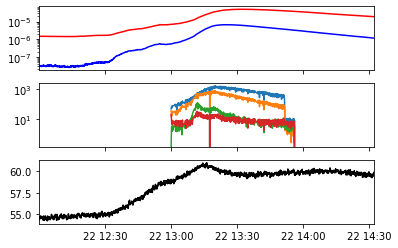

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import scipy.stats
from sunpy.time import parse_time
from matplotlib import dates
from scipy.signal import savgol_filter
from sunpy import timeseries as ts 
from scipy.io import readsav 
from astropy.io import fits
import datetime
from case_study_m import make_rhessi_lc

import seaborn as sns
sns.set_context("paper", font_scale=1.2)
plt.rcParams['xtick.direction'] = "in"
plt.rcParams['ytick.direction'] = "in"
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True


plt.rcParams['font.family'] = 'Helvetica'
cmap_paper = plt.cm.viridis
sid_file = '/Users/laurahayes/ionospheric_work/vlf_data_all_birr/sid_alll/20130522_000000_NAA_S-0055.csv'
goes_file = '/Users/laurahayes/QPP/stats_study/TEBBS/goes_rawdata/go1520130522.fits'

def calc_amp(x):
    return 20*np.log10(x + 5) - 61 + 107

def sid_to_series(file, amp=False):

    sid = pd.read_csv(file, comment="#", names=["times", "data"])
    tt = parse_time(sid["times"]).datetime
    if amp:
        ser = pd.Series(calc_amp(sid["data"].values), index=tt)
    else:
        ser = pd.Series(sid["data"].values, index=tt)       
    ser.sort_index(inplace=True)
    return ser

In [2]:
flare_start = "2013-05-22 12:00:00"
flare_end = "2013-05-22 15:00:00"


sid_data = sid_to_series(sid_file)
goes_data = ts.TimeSeries(goes_file)

gl = goes_data.to_dataframe()["xrsb"]
gs = goes_data.to_dataframe()["xrsa"]

gl_flare = gl.truncate(flare_start, flare_end)
gs_flare = gs.truncate(flare_start, flare_end)

sid_flare = sid_data.truncate(flare_start, flare_end)

In [3]:


rhe_data = readsav("rhessi_lc_corrected_20130522.sav")
rhe_times = parse_time(rhe_data["hsi_times"], format="utime").datetime
rhe_2550 = np.squeeze(rhe_data["hsi_counts_2550"])
rhe_50100 = np.squeeze(rhe_data["hsi_counts_50100"])
rhe_1225 = np.squeeze(rhe_data["hsi_counts_1225"])
rhe_612 = np.squeeze(rhe_data["hsi_counts_0612"])


In [76]:
rhessi_2550 = pd.Series(rhe_2550, index=rhe_times)
rhessi_50100 = pd.Series(rhe_50100, index=rhe_times)
rhessi_1225 = pd.Series(rhe_1225, index=rhe_times)

In [5]:
rhessi_2550.resample("10s").mean()

2013-05-22 13:00:00    0.229133
2013-05-22 13:00:10    2.746361
2013-05-22 13:00:20    2.496302
2013-05-22 13:00:30    2.391762
2013-05-22 13:00:40    3.314064
                         ...   
2013-05-22 13:59:10    0.000000
2013-05-22 13:59:20    0.000000
2013-05-22 13:59:30    0.000000
2013-05-22 13:59:40    0.000000
2013-05-22 13:59:50    0.000000
Freq: 10S, Length: 360, dtype: float32

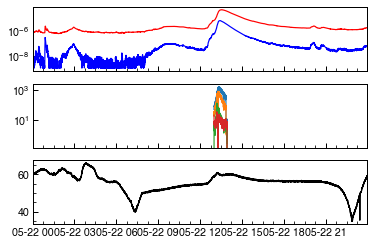

In [6]:
fig, ax = plt.subplots(3, sharex=True)

ax[0].plot(gl, color="r")
ax[0].plot(gs, color="b")
ax[0].set_xlim(gl.index[0], gl.index[-1])
ax[0].set_yscale("log")

ax[1].plot(rhe_times, rhe_612, label="6-12keV")
ax[1].plot(rhe_times, rhe_1225, label="12-25keV")
ax[1].plot(rhe_times, rhe_2550, label="25-50keV")
ax[1].plot(rhe_times, rhe_50100, label="50-100keV")
ax[1].set_yscale("log")


ax[2].plot(calc_amp(sid_data), color="k")


In [7]:
gl = gl.resample("5s").mean()


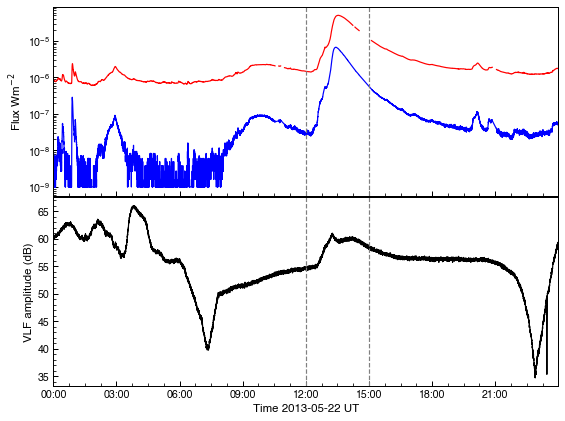

In [8]:
fig, ax = plt.subplots(2, sharex=True, figsize=(8, 6))

ax[0].plot(gl, color="r")
ax[0].plot(gs, color="b")
ax[0].set_xlim(gl.index[0], gl.index[-1])
ax[0].set_yscale("log")
ax[0].set_ylabel("Flux Wm$^{-2}$")
# ax2 = ax[0].twinx()
# ax2.plot(gl.index, np.gradient(gl))


ax[1].plot(calc_amp(sid_data), color="k")
ax[1].xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
ax[1].set_xlabel("Time {:s} UT".format(gl.index[10].strftime("%Y-%m-%d")))
ax[1].set_ylabel("VLF amplitude (dB)")

for a in ax:
    a.axvline(pd.to_datetime(flare_start), color="grey", ls="dashed")
    a.axvline(pd.to_datetime(flare_end), color="grey", ls="dashed")              
plt.tight_layout()
plt.subplots_adjust(hspace=0.01)
plt.savefig("example_m.png", facecolor="w", dpi=300, bbox_inches="tight")

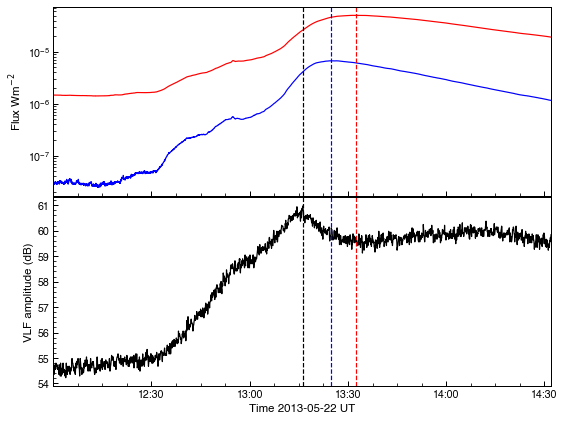

In [9]:
fig, ax = plt.subplots(2, sharex=True, figsize=(8, 6))

ax[0].plot(gl_flare, color="r")
ax[0].plot(gs_flare, color="b")
ax[0].set_xlim(gl_flare.index[0], gl_flare.index[-1])
ax[0].set_yscale("log")
ax[0].set_ylabel("Flux Wm$^{-2}$")
# ax2 = ax[0].twinx()
# ax2.plot(gl.index, np.gradient(gl))


ax[1].plot(calc_amp(sid_flare), color="k")
ax[1].xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
ax[1].set_xlabel("Time {:s} UT".format(gl_flare.index[10].strftime("%Y-%m-%d")))
ax[1].set_ylabel("VLF amplitude (dB)")


for a in ax:
    a.axvline(gl_flare.index[np.argmax(gl_flare)], color="r", ls="dashed")
    a.axvline(gs_flare.index[np.argmax(gs_flare)], color="b", ls="dashed")
    a.axvline(sid_flare.index[np.argmax(sid_flare)], color="k", ls="dashed")
    
plt.tight_layout()
plt.subplots_adjust(hspace=0.01)
plt.savefig("example_m_flare.png", facecolor="w", dpi=300, bbox_inches="tight")

In [39]:
vlf_stats = pd.read_csv("vlf_stats_results_new.csv")

In [44]:
vlf_stats.iloc[73]

start_time_goes         2013-05-22 13:08:00
peak_flare_gl                      0.000051
peak_flare_gs                      0.000007
peak_flare_gl-bg                    0.00004
peak_flare_gs-bg                   0.000006
max_vlf_volts                       0.45071
abs_vlf_volts                      2.645073
background_sid_db                 54.959696
background_sid_volts              -2.194363
background_gl                       0.00001
background_gs                      0.000001
max_vlf_db                        60.728048
abs_vlf_db                         5.768352
dt_value_gl                       -1006.072
dt_value_gs                        -545.279
index                                   531
event_starttime         2013-05-22 13:08:00
event_peaktime          2013-05-22 13:32:00
event_endtime           2013-05-22 14:08:00
goes_class_ind                            M
goes_class                             M5.0
goes_class_val                      0.00005
integrated_flux                 

In [45]:
vlf_flare = vlf_stats.iloc[73]

In [47]:
vlf_flare["event_starttime"]

'2013-05-22 13:08:00'

In [50]:
window_sec =  (sid_flare.index[1] - sid_flare.index[0]).total_seconds()
window = int((2*60)/window_sec)
if window%2 == 0:
    window = window+1
sid_resample_db = pd.Series(savgol_filter(sid_flare, int(window), 3), index=sid_flare.index)
sid_resample_flare_db = sid_resample_db.truncate(vlf_flare["event_starttime"], vlf_flare["event_endtime"])       

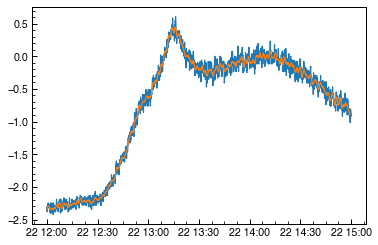

In [55]:

plt.plot(sid_flare)
plt.plot(sid_resample_db)

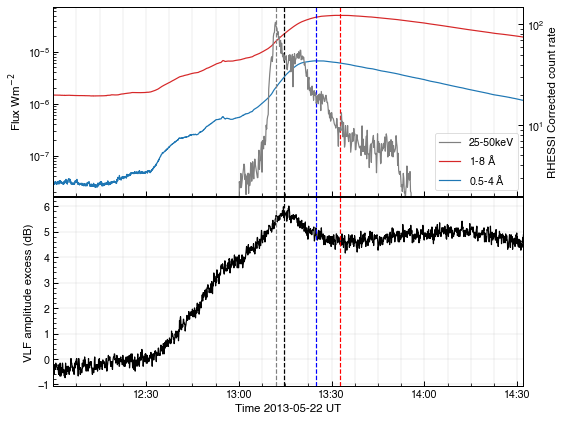

In [85]:
fig, ax = plt.subplots(2, sharex=True, figsize=(8, 6))

ax[0].plot(gl_flare, color="tab:red")
ax[0].plot(gs_flare, color="tab:blue")
ax[0].set_xlim(gl_flare.index[0], gl_flare.index[-1])
ax[0].set_yscale("log")
ax[0].set_ylabel("Flux Wm$^{-2}$")
# ax2 = ax[0].twinx()
# ax2.plot(gl.index, np.gradient(gl))


ax[1].plot(calc_amp(sid_flare)-54.959696, color="k")
ax[1].xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
ax[1].set_xlabel("Time {:s} UT".format(gl_flare.index[10].strftime("%Y-%m-%d")))
ax[1].set_ylabel("VLF amplitude excess (dB)")

ax2 = ax[0].twinx()
ax2.plot(rhessi_2550.resample("10s").mean(), label="25-50keV", color="grey")
ax2.plot(np.nan, color="tab:red", label="1-8 $\mathrm{\AA}$")
ax2.plot(np.nan, color="tab:blue", label="0.5-4 $\mathrm{\AA}$")

ax2.legend(loc="lower right")
ax2.set_yscale("log")
ax2.set_ylim(2, 150)
ax2.set_ylabel("")
ax2.set_ylabel("RHESSI Corrected count rate")

for a in ax:
    a.axvline(gl_flare.index[np.argmax(gl_flare)], color="r", ls="dashed")
    a.axvline(gs_flare.index[np.argmax(gs_flare)], color="b", ls="dashed")
    a.axvline(sid_flare.index[895], color="k", ls="dashed")
    a.axvline(rhessi_2550.index[178], color="grey", ls="dashed")


    
ax[0].xaxis.grid(which="both", lw=0.2, zorder=0)
ax[1].grid(which="major", lw=0.2, zorder=0)
ax[1].xaxis.grid(which="both", lw=0.2, zorder=0)
ax2.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
plt.tight_layout()
plt.subplots_adjust(hspace=0.01)
plt.savefig("./final_paper_plots/example_m_flare2.png", facecolor="w", dpi=300, bbox_inches="tight")

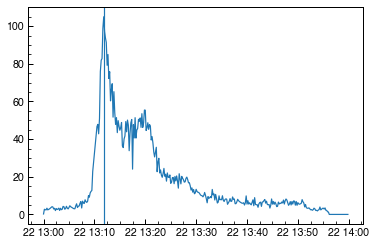

In [16]:
plt.plot(rhessi_2550.resample("10s").mean())
plt.axvline(rhessi_2550.index[178])

In [19]:
rhessi_2550.index[178]

Timestamp('2013-05-22 13:11:52')

In [32]:
(sid_flare.index[895] - rhessi_2550.index[178]).total_seconds()/60

2.716666666666667

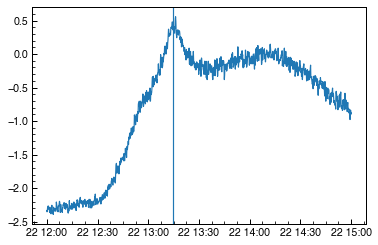

In [31]:
plt.plot(sid_flare.resample("10s").mean())
plt.axvline(sid_flare.index[895])

In [27]:
np.argmax(sid_flare)

914

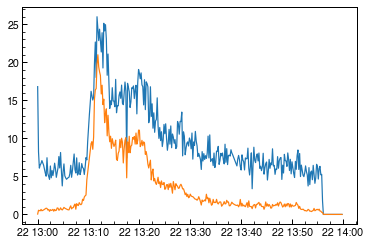

In [83]:
plt.plot(rhessi_50100.resample("10s").mean())
plt.plot(rhessi_2550.resample("10s").mean()/5)